In [575]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [576]:
DATASET_PATH = '../input/leak-detection-audio/Hydrophone/Looped'

data_dir = pathlib.Path(DATASET_PATH)
# if not data_dir.exists():
#   tf.keras.utils.get_file(
#       'mini_speech_commands.zip',
#       origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
#       extract=True,
#       cache_dir='.', cache_subdir='data')

In [577]:
Leaks = np.array(tf.io.gfile.listdir(str(data_dir)))
Leaks = Leaks[Leaks != 'README.md']
print('Leaks:', Leaks)

Leaks: ['Gasket Leak' 'Orifice Leak' 'Longitudinal Crack' 'NonLeak'
 'Circumferential Crack']


In [578]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/Leaks[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 60
Number of examples per label: 12
Example file tensor: tf.Tensor(b'../input/leak-detection-audio/Hydrophone/Looped/Gasket Leak/LO_GL_ND_S_H1.wav', shape=(), dtype=string)


In [579]:
train_files = filenames[:50]
val_files = filenames[50: 50 + 30]
test_files = filenames[-10:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 50
Validation set size 10
Test set size 10


In [580]:
test_file = tf.io.read_file(DATASET_PATH+'/Gasket Leak/LO_GL_0.18 LPS_H2.wav')
test_audio, _ = tf.audio.decode_wav(contents=test_file)
test_audio.shape

TensorShape([580920, 1])

In [581]:
def decode_audio(audio_binary):
  # Decode WAV-encoded audio files to `float32` tensors, normalized
  # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  # Since all the data is single channel (mono), drop the `channels`
  # axis from the array.
  return tf.squeeze(audio, axis=-1)

In [582]:
def get_label(file_path):
  parts = tf.strings.split(
      input=file_path,
      sep=os.path.sep)
  # Note: You'll use indexing here instead of tuple unpacking to enable this
  # to work in a TensorFlow graph.
  return parts[-2]

In [583]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [584]:
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

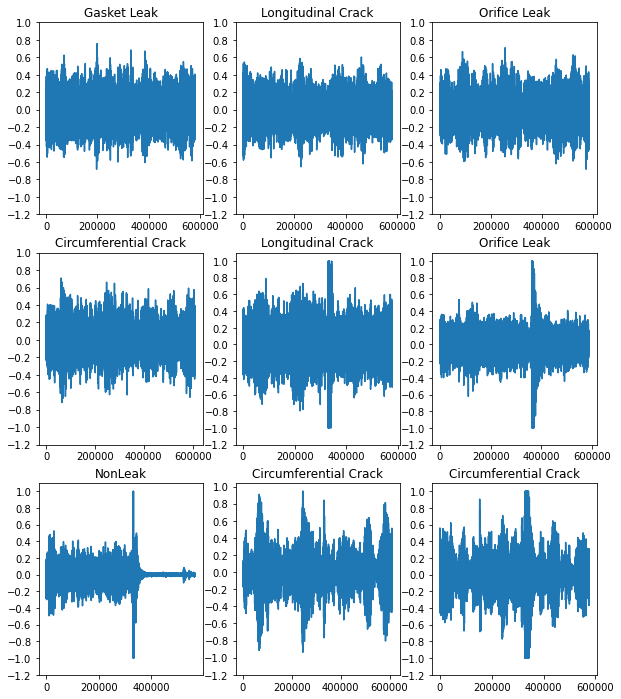

In [585]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [586]:
def get_spectrogram(waveform):
  # Zero-padding for an audio waveform with less than 16,000 samples.
  input_len = 20000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [20000] - tf.shape(waveform),
      dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  equal_length = tf.concat([waveform, zero_padding], 0)
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [587]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=20000))

Label: Gasket Leak
Waveform shape: (579920,)
Spectrogram shape: (155, 129, 1)
Audio playback


In [588]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

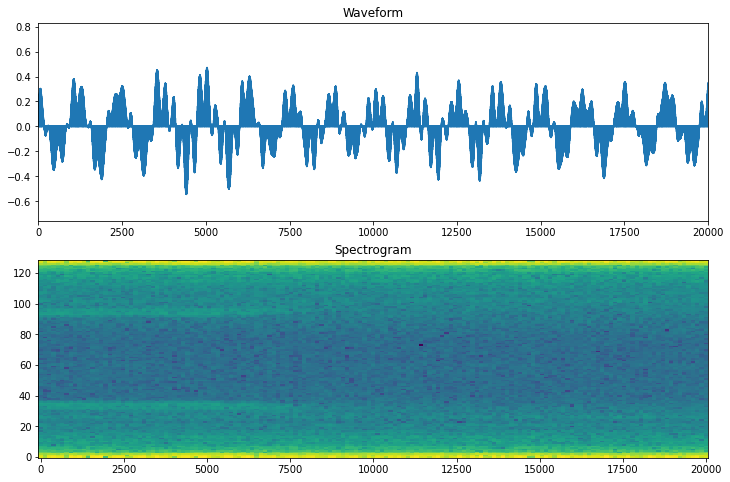

In [589]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 20000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [590]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  label_id = tf.argmax(label == Leaks)
  return spectrogram, label_id

In [591]:
spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)

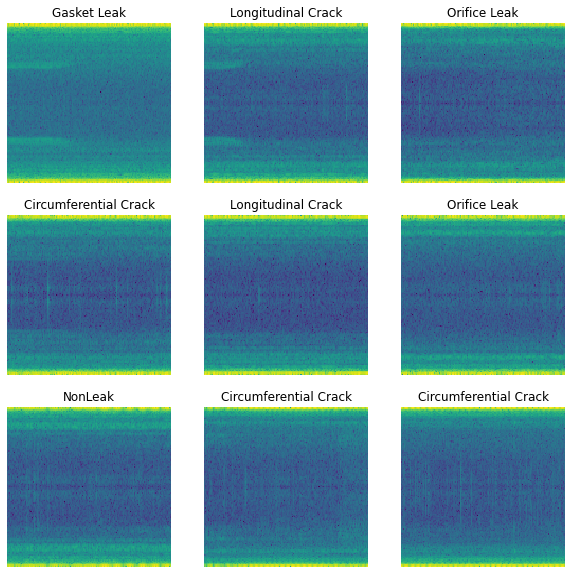

In [592]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(Leaks[label_id.numpy()])
  ax.axis('off')

plt.show()

In [593]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)
  return output_ds

In [594]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [595]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [596]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [597]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(Leaks)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (155, 129, 1)
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_20 (Resizing)       (None, 32, 32, 1)         0         
_________________________________________________________________
normalization_20 (Normalizat (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_20 (Flatten)      

In [598]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [599]:
from keras.callbacks import EarlyStopping
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')

In [600]:
EPOCHS = 100
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
   callbacks=[early]
)

Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 1.6144 - accuracy: 0.1600 - val_loss: 1.6399 - val_accuracy: 0.2000
Epoch 2/100
1/1 [==============================] - 0s 57ms/step - loss: 1.6144 - accuracy: 0.2600 - val_loss: 1.6552 - val_accuracy: 0.1000
Epoch 3/100
1/1 [==============================] - 0s 64ms/step - loss: 1.6211 - accuracy: 0.2800 - val_loss: 1.6327 - val_accuracy: 0.1000
Epoch 4/100
1/1 [==============================] - 0s 61ms/step - loss: 1.6222 - accuracy: 0.2000 - val_loss: 1.6020 - val_accuracy: 0.1000
Epoch 5/100
1/1 [==============================] - 0s 60ms/step - loss: 1.5648 - accuracy: 0.3600 - val_loss: 1.5899 - val_accuracy: 0.1000
Epoch 6/100
1/1 [==============================] - 0s 71ms/step - loss: 1.5642 - accuracy: 0.2200 - val_loss: 1.5841 - val_accuracy: 0.2000
Epoch 7/100
1/1 [==============================] - 0s 60ms/step - loss: 1.5290 - accuracy: 0.3800 - val_loss: 1.5744 - val_accuracy: 0.2000
Epoch 8/100
1/1 [=====

Text(0, 0.5, 'Loss')

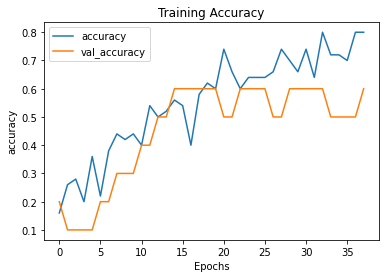

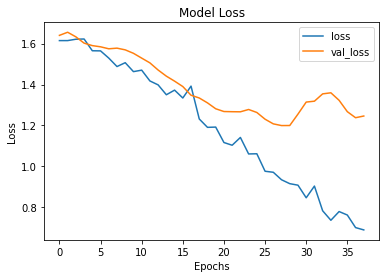

In [601]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history)

pd.DataFrame(history.history)[["accuracy", "val_accuracy"]].plot()
plt.title("Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("accuracy")

pd.DataFrame(history.history)[["loss", "val_loss"]].plot()
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

In [602]:
model.save('my_model.h5')
